<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias_ngrams_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
import pickle
import pyarrow.parquet as pq
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster, single, complete, average
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 2 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [3]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [4]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [19]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(28122, 3)


In [20]:
dfDados = dfDados.sample(frac=0.50, random_state=123)
print(dfDados.shape)

(14061, 3)


In [7]:
dfDados.columns

Index(['text', 'category', 'category_nro'], dtype='object')

62


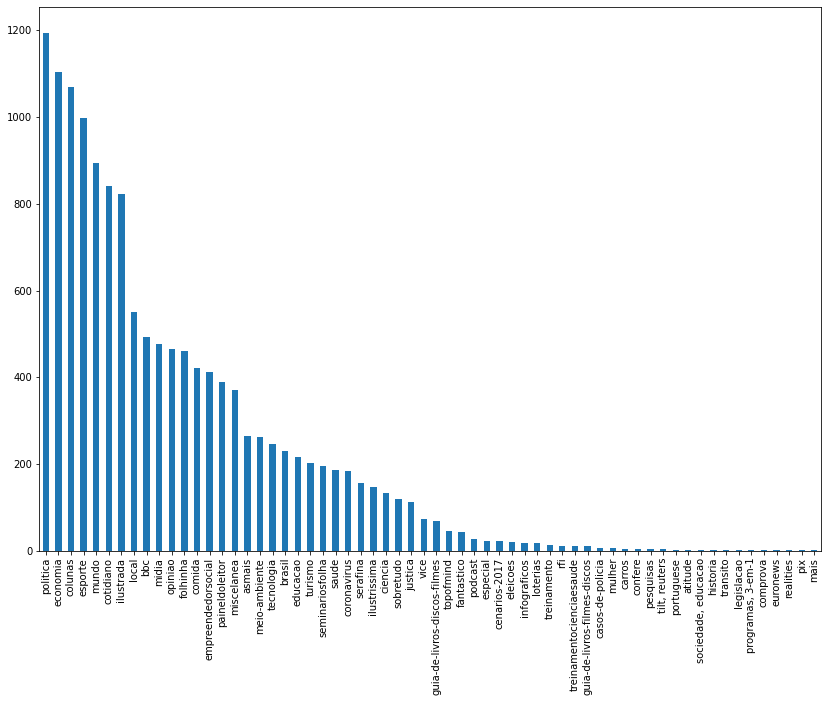

In [8]:
df = dfDados['category'].value_counts()
print(dfDados['category'].unique().size)
df.plot.bar(figsize=(14,10))


In [9]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data]   Unzipping stemmers/rslp.zip.
CPU times: user 1.26 s, sys: 397 ms, total: 1.65 s
Wall time: 3min 37s


In [10]:
print(dfPreProc.shape)
dfPreProc.head()

(14061, 3)


,text,category,category_nro
20068,paul paix bols torn profiss médic gabriel mach jornal raíss mach cunh cinc ano sóc bols loj onlin comercializ maior model r empresár invest r abr empr fatur r milhã cresc form mod am assunt sempr busc refer viag internet blog red soc ach bols desej diz jornal coleç ver lanç prim it mão obr artesan bols croch cheg loj nest seman próx pass vend peç atac oper começ fever sequ empresár planej lev bols argentin,sobretudo,17
18920,supervi compreend sab marcy shermanlewil funcionár serviç atend client falt algum dia pal mor hor dal mal alzheim mãe consult médic pai viv cim baix estr diss marcy filh únic acab férias licenç médic folg entant chef recus dar temp adic long empreg sab quer temp escritóri pergunt qual plan vai faz colocál cas repous plan marcy demit marid engenh aposent pud mud overland park kans eua cidad pal st joseph missour sab pod ach empreg ach começ funcion perfeit porém mal alzheim avanç direç marcy receb ligaç escritóri pal mistur remédi pai cad vez descontrol mãe pass mão fogã queim braç queimad grav apavor diss marcy filh deix empreg nov possi sempr emb pal morr marid ano receb diagnóst alzheim ano exig atenç temp integr ano recémcomplet lament decis pergunt dia volt trabalh licençafamíl remuner agor obrigatór trê est eua prova apreci vár assemble legisl ano vem pod ter ampli carr brasil serv públic possu benefíci licenç motiv doenç pesso famíl próx prim mê venc sofr cort geral reduç progress salári cheg licenç remuner pod ser acompanh oa cônjug companheiro pal filh ente padrast madrast depend atest necess períc médic trabalh set priv aind benefic previs legal ness sent tramit câm sen projet busc equipar celet serv públic necessár licenç dev ser negoci licenç estimas cerc milh americ cuid alguém ano maior empreg segund estud recent respeit trabalh precis faz malabar particul complic cuid filh felic cont filh saud tornas razoa previs long temp tir inevit infecç ouv doenç passag cuid idos entant exig reviravolt mud vid avis qued incapacit acid vascul grav necess assist pesso idos costum aument funç vid long trabalh cuid temp pal form intens cas filh além diss impact emoc difer segund kenneth mat dire pesquis famili and work institut cri crianç pass event feliz mai independ cuid idos pass experi trist legisl lei feder trat licenç médic famili ajud algum cuid trabalh exempl proteg empreg lei limitaç atend soment popul ativ exceç empr menos funcion soment cuid cônjug pai filh inclu parent afin avó clar remuner nov york lei aprov assemble legisl prev seman licenç pag ano trabalh mei períod integr cuid recémnasc crianç recémadot famili problem saúd grav govern andrew m cuom compromet sancionál organizaç empresar levant objeç emb estud lei californi prev seil seman licenç constat efeit mín sobr empreg outr est inclu connecticut dev avali legisl simil ano vem conjunt capit americ parlamant democrat apresent recent projet lei fic conhec lei famíl perd rend trabalh cuid adult ano metad inform algum influ deletér serviç inform associ aposent nation allianc caregiving dess pesso falt formal reduz hor encontr empreg menos exig aposent ant planej deix trabalh fic parent consequ financ perd rend atual futur pod revel espec problemá mulh méd ganh menos comu cuid sustent use tod poupanç aposentad diss marcy shermanlewil após ano desempreg enfrent reduç benefíci previd soc licenç remuner vai resolv tod dilem cuid clar talv funcion melhor dur mes ano ajud pal recuper cirurg quadril transportál consult colabor faz compr cozinh pai maryann manelsk vez fic cad vez incapacit parkinson precis tom remédi vár vez dia diss cineast novaiorquin ano precis troc lençol tod dia assim dur ano defend projet lei nov york seman licenç remuner anual salv tod ano pass cuid porém talv cineast pod trabalh temp,saude,13
3618,rio jan cômic trág atual situ polít sac gat tod mi enquant país parec naufrag mar corrupç gener exceç gross man depend falcatru dela delat acus si temp naçã mergulh città dolent dant coloc port infe

In [ ]:
#dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv',index=False)
#dfPreProc = pd.read_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')
#dfPreProc['text'] = dfPreProc['text'].astype('unicode')

In [108]:
V = processaVetorizacao(dfPreProc,min_fr=0.05, max_fr=0.7, ngrams=(1,2))
X_tfidf = retornaMatriztfIdf(V)

In [109]:
%%time
#https://www.kaggle.com/tchainzzz/agglomerative-document-clustering-on-cord-19

dist = 1 - cosine_similarity(X_tfidf)
dist = dist - dist.min()
linkage_matrix = average(dist) #ward(dist)

CPU times: user 25min 27s, sys: 6.8 s, total: 25min 34s
Wall time: 25min 25s


In [110]:
with open('./amostra_news_integrada/amostra_4/dist_cosine.npy', 'wb') as f:
    np.save(f, dist)
f.close()

In [111]:
with open('./amostra_news_integrada/amostra_4/dist_cosine.npy', 'rb') as f:
  dist = np.load(f)
f.close()


(14061, 14061)

In [42]:
!ls ./amostra_news_integrada/amostra_4/ -lh

total 1.6G
-rw------- 1 root root  80M Aug 25 11:51 amostra.csv
-rw------- 1 root root 1.5G Aug 26 18:59 dist_cosine.npy


* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


In [ ]:
#X = np.ones((X_tfidf.shape))
#X_tfidf.toarray(out=X)


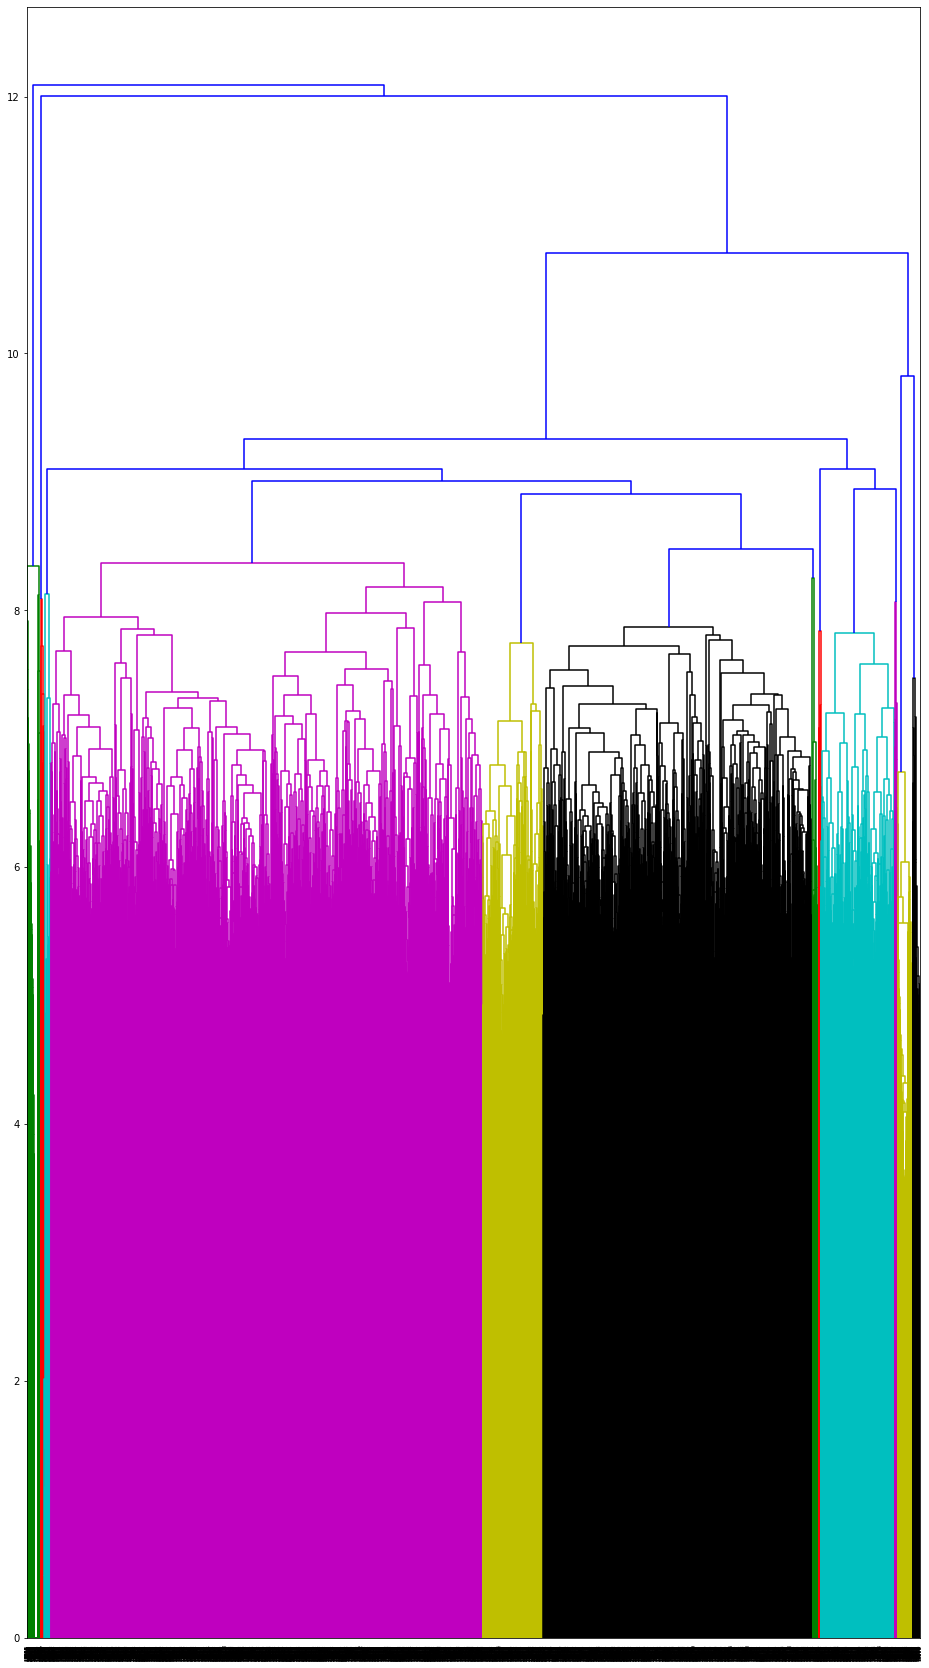

CPU times: user 5min 56s, sys: 32.2 s, total: 6min 28s
Wall time: 6min 15s


In [112]:
%%time
plt.figure(figsize=(16, 30))
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

Similaridade Coseno

In [ ]:
#X_cosine = X_tfidf.toarray()
#print(np.where(~X_cosine.any(axis=1))[0])
#z = np.where(~X_cosine.any(axis=1))[0]
#for i in z:
#  X_cosine[i] = np.ones(X_cosine[i].shape)*1/100
#print(np.where(~X_cosine.any(axis=1))[0])

[   38   122   303   712   734  1017  1037  1072  1243  1330  1519  1864
  2098  2390  2676  3143  3702  3817  3843  4121  4161  4240  4282  4332
  4345  4390  4659  4952  5050  5146  5408  5555  5788  5840  5908  6080
  6154  6518  6529  6647  6901  6958  7012  7067  7121  7424  7470  7532
  7662  7701  7853  7897  8037  8242  8501  8573  8873  8884  9165  9240
  9855 10096 10323 10728 10821 11072 11248 11389 11403 11604 11762 11833
 11882 12077 12339 12752 12850 12962 13274 13400 13513 13842]
[]


Clusterizando

In [113]:
#model= AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average')
#dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)
k=4
model= AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
y_pred = model.fit_predict(dist)

<BarContainer object of 4 artists>

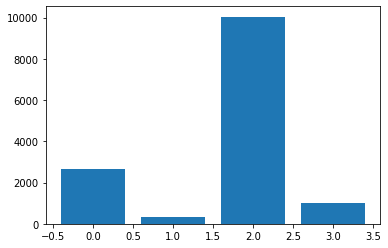

In [114]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


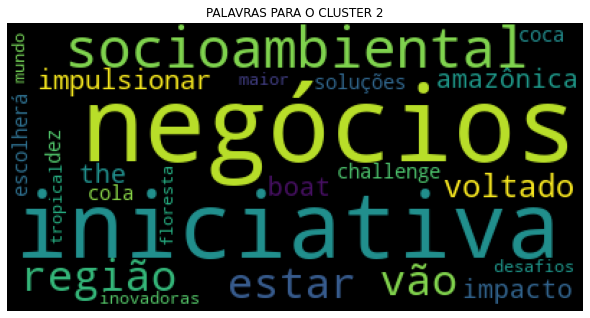

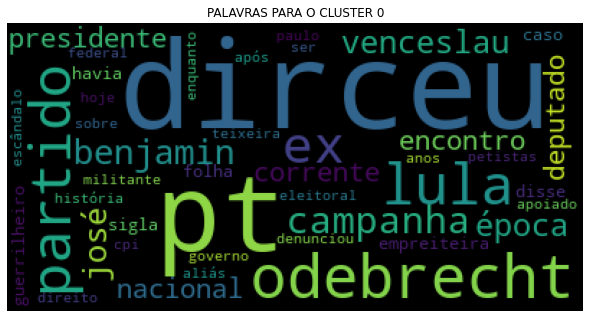

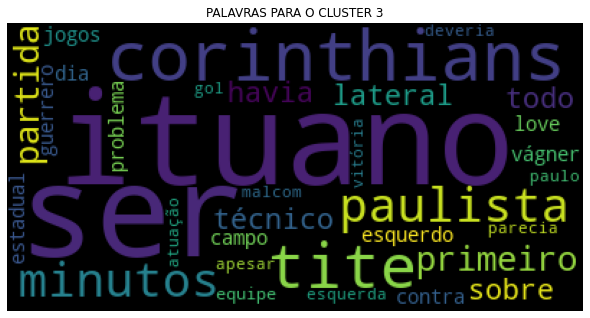

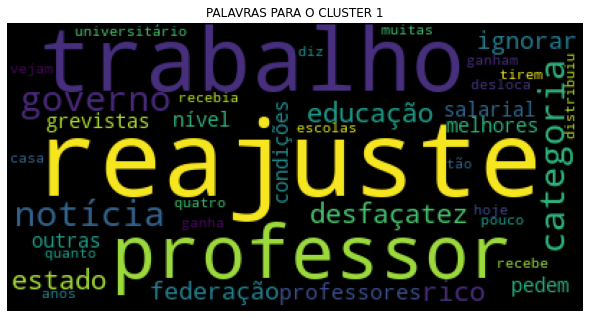

In [120]:
#dfconta = dfDados['y_pred'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['y_pred'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),500,str(y),sw)

Silhouete

In [116]:
#https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111
from sklearn.metrics import silhouette_samples,silhouette_score
silhouette_vals = silhouette_samples(dist,y_pred)
silhouette_vals

array([0.07573604, 0.03852523, 0.10682469, ..., 0.07833354, 0.1339484 ,
       0.15897066])

In [117]:

for i, cluster in enumerate(np.unique(y_pred)):
  m = np.mean(silhouette_vals[y_pred ==cluster])
  print(cluster, m)
print('média:', np.mean(silhouette_vals))

0 0.13141057412448923
1 0.281671503608442
2 0.030534750022684912
3 0.1900147433417966
média: 0.06724120693250667


Para k=4<br>
0 0.13141057412448923<br>
1 0.281671503608442<br>
2 0.030534750022684912<br>
3 0.1900147433417966<br>
média: 0.06724120693250667<br>
Score: 0.1715389074135818


In [118]:
silhouette_score(dist,y_pred,metric='cosine')

0.1715389074135818

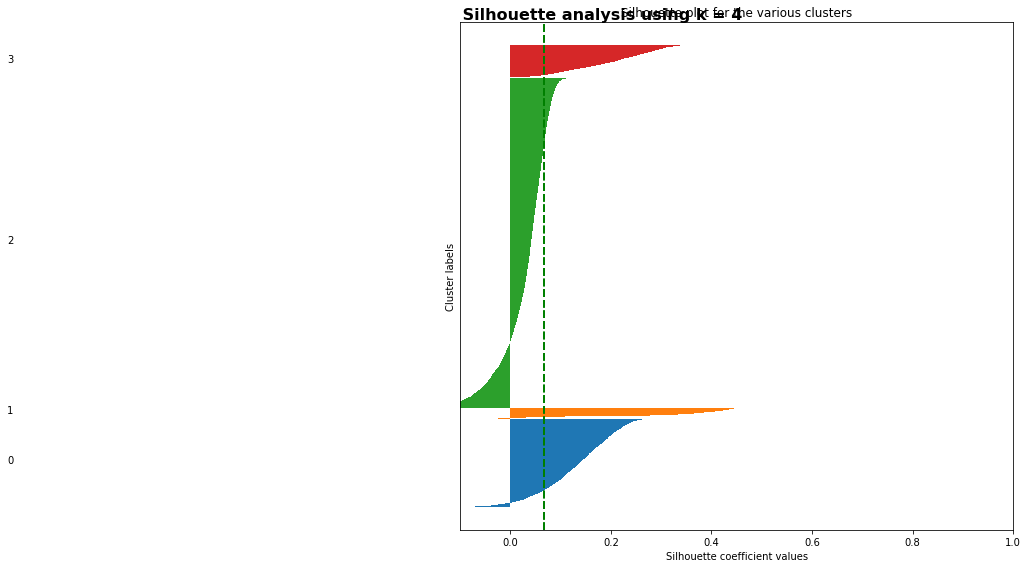

In [121]:
# silhouette plot
y_ticks = []
y_lower = y_upper = 0
fig, ax = plt.subplots(figsize=(12,8))
for i,cluster in enumerate(np.unique(y_pred)):
   cluster_silhouette_vals = silhouette_vals[y_pred ==cluster]
   cluster_silhouette_vals.sort()
   y_upper += len(cluster_silhouette_vals)
   
   ax.barh(range(y_lower,y_upper), cluster_silhouette_vals,height =1);
   ax.text(-1,(y_lower+y_upper)/2,str(i))
   y_lower += len(cluster_silhouette_vals)
       
   # Get the average silhouette score 
   avg_score = np.mean(silhouette_vals)
   ax.axvline(avg_score,linestyle ='--',
   linewidth =2,color = 'green')
   ax.set_yticks([])
   ax.set_xlim([-0.1, 1])
   ax.set_xlabel('Silhouette coefficient values')
   ax.set_ylabel('Cluster labels')
   ax.set_title('Silhouette plot for the various clusters');
    
   plt.tight_layout()
   plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16,fontweight = 'semibold')

In [46]:
dfDados[dfDados['y_pred']==3][['category','y_pred']].groupby('category').count().reset_index().rename(columns={'y_pred':'qtd'}).sort_values(by='qtd', ascending=False)

,category,qtd
23,ilustrada,703
11,cotidiano,587
27,local,468
8,colunas,443
20,folhinha,426
33,mundo,370
30,midia,369
2,bbc,366
9,comida,332
12,economia,204


In [47]:
dfDados[dfDados['y_pred']==3].sample(50)

text  ... y_pred
11130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          